In [1]:
# Import Libraries
#%matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel

In [27]:

#-------------------------------------Load, Inspect and Transform the Accelerometer Data--------------------------------
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))
    

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [21]:
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

In [8]:
# Load data set containing all the data from csv
df = read_data('../WISDM_ar_v1.1_raw.txt')

# Describe the data
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


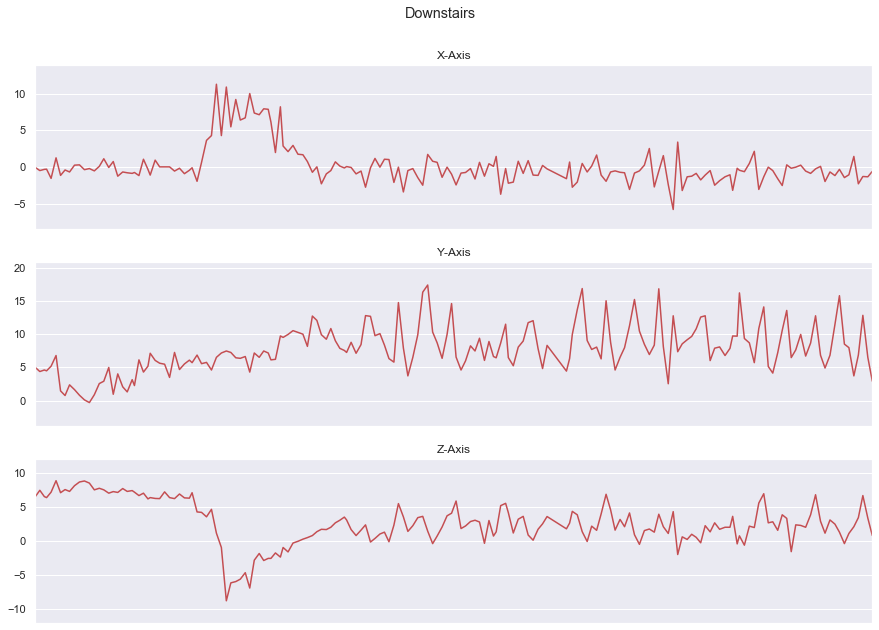

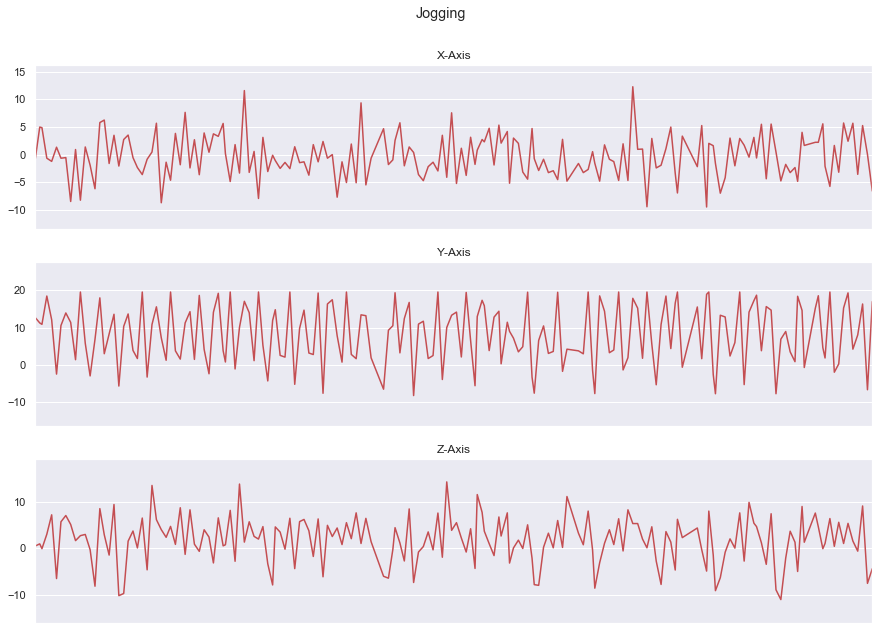

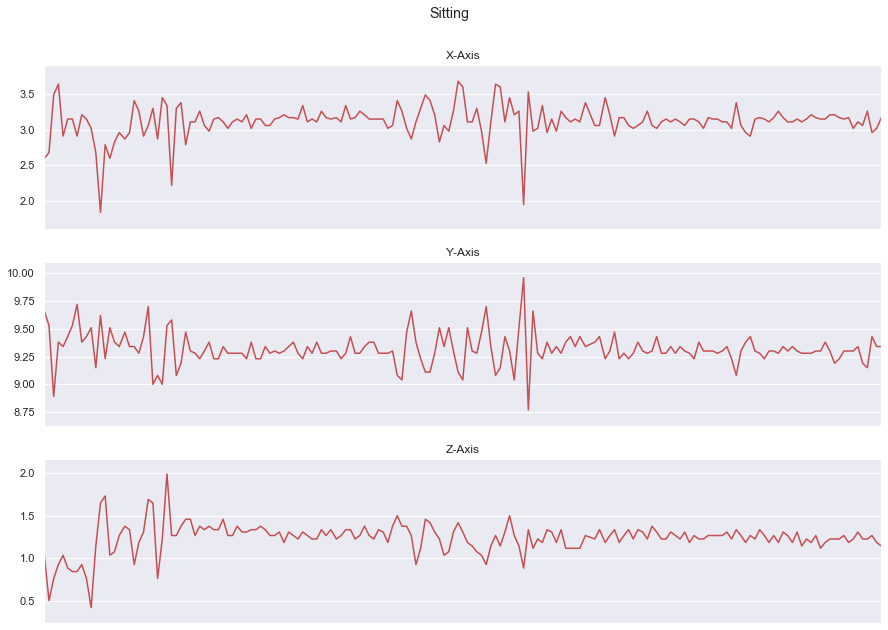

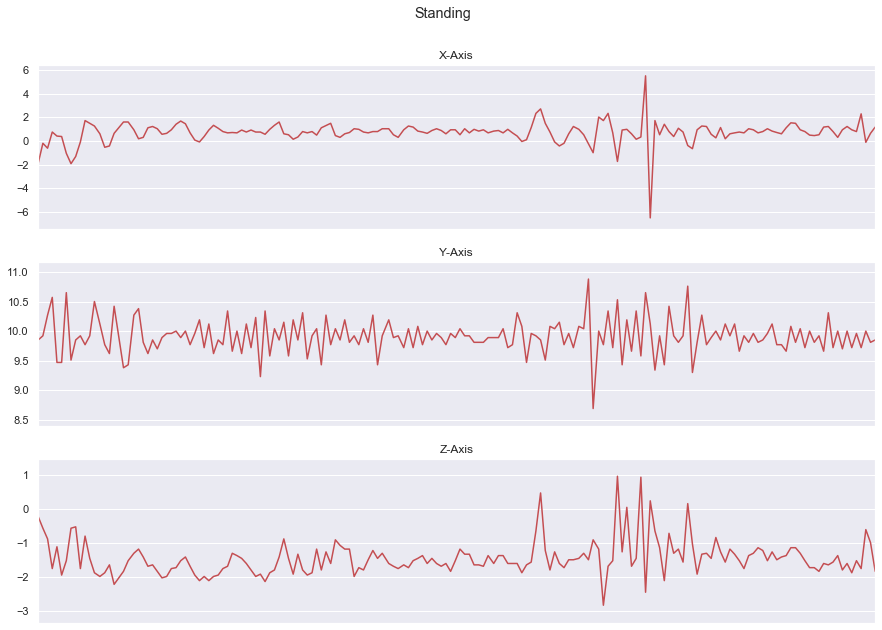

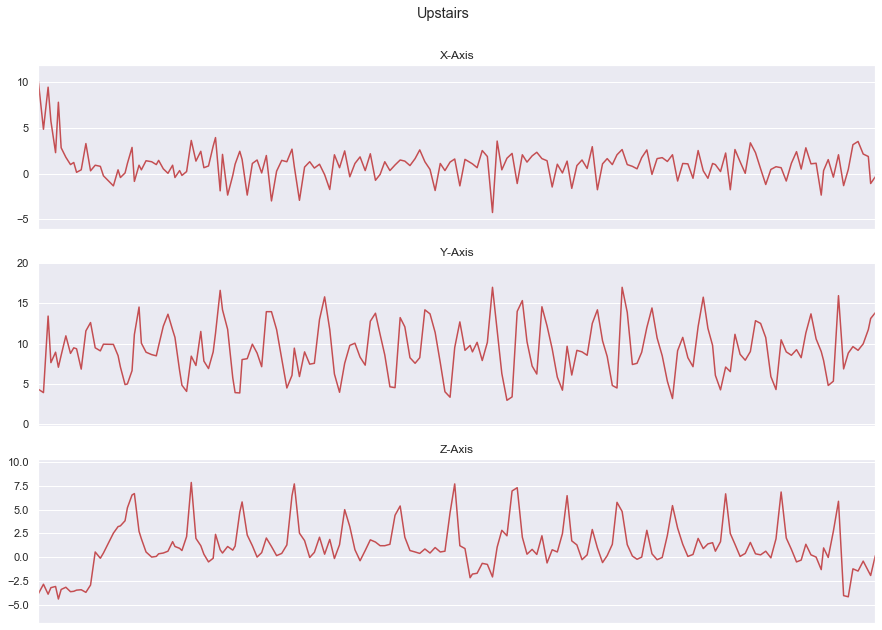

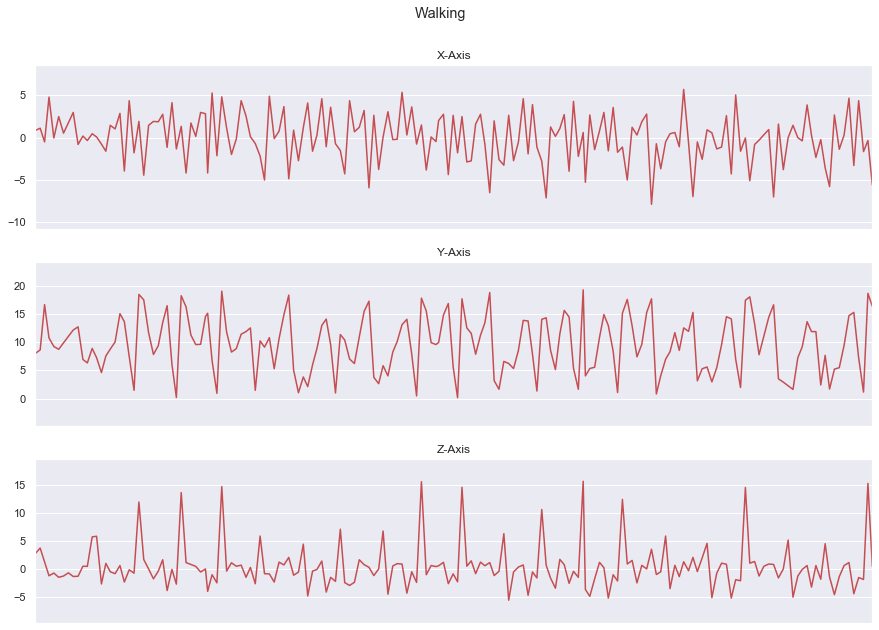

In [9]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [10]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [11]:
#------------------------------------Split Data into Training and Test Set---------------------------------------
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]


#------------------------Normalize features for training data set (values between 0 and 1)-----------------------
# This must also be done to testing set later
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})



pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [14]:
#--------------------------Reshape Train Data into Segments--------------------------------------
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)


# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))



input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)


x_train = x_train.astype('float32')
y_train = y_train.astype('float32')


y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 240)
input_shape: 240
New y_train shape:  (20868, 6)


In [16]:
#--------------------------Reshape Test Data into Segments and Prepare for Keras--------------------------------------

x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

print('x_train shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_train shape: ', y_test.shape)


# Set input & output dimensions
num_time_periods, num_sensors = x_test.shape[1], x_test.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))



input_shape = (num_time_periods*num_sensors)
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_test.shape)
print('input_shape:', input_shape)


x_test = x_test.astype('float32')
y_test = y_test.astype('float32')


y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_train shape: ', y_test_hot.shape)


x_train shape:  (6584, 80, 3)
6584 training samples
y_train shape:  (6584,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (6584, 240)
input_shape: 240
New y_train shape:  (6584, 6)


In [17]:
#-------------------------Create Deep Neural Network Model in Keras-------------------------------------
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
#-----------------------------------Fit the DNN Model in Keras-------------------------------------------
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model/best_model.{val_acc:.2f}-{acc:.2f}-{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [26]:
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 9s 567us/step - loss: 0.5181 - acc: 0.8077 - val_loss: 0.6341 - val_acc: 0.8222
Epoch 2/50
16694/16694 [==============================] - 8s 490us/step - loss: 0.4817 - acc: 0.8205 - val_loss: 0.6298 - val_acc: 0.8184
Epoch 3/50
16694/16694 [==============================] - 8s 508us/step - loss: 0.4620 - acc: 0.8313 - val_loss: 0.6483 - val_acc: 0.8100
Epoch 4/50
16694/16694 [==============================] - 9s 509us/step - loss: 0.4470 - acc: 0.8335 - val_loss: 0.6364 - val_acc: 0.8206
Epoch 5/50
16694/16694 [==============================] - 8s 493us/step - loss: 0.4312 - acc: 0.8430 - val_loss: 0.6548 - val_acc: 0.8124
Epoch 6/50
16694/16694 [==============================] - 8s 468us/step - loss: 0.4149 - acc: 0.8498 - val_loss: 0.6680 - val_acc: 0.7755
Epoch 7/50
16694/16694 [==============================] - 8s 462us/step - loss: 0.4071 - acc: 0.8532 - val_loss: 0.6849 - v

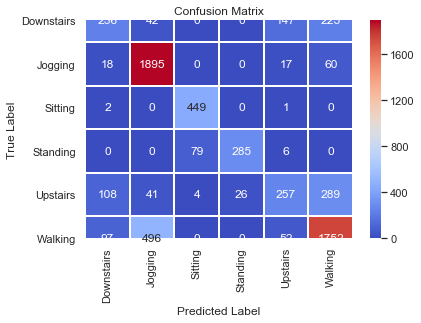

              precision    recall  f1-score   support

         0.0       0.51      0.36      0.42       650
         1.0       0.77      0.95      0.85      1990
         2.0       0.84      0.99      0.91       452
         3.0       0.92      0.77      0.84       370
         4.0       0.54      0.35      0.43       725
         5.0       0.75      0.73      0.74      2397

    accuracy                           0.74      6584
   macro avg       0.72      0.69      0.70      6584
weighted avg       0.72      0.74      0.73      6584



In [28]:
# Print confusion matrix for training data

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)

show_confusion_matrix(y_test, max_y_pred_test)

print(classification_report(y_test, max_y_pred_test))